# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [182]:
# Load pickled data
import pickle
# Load numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)   
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


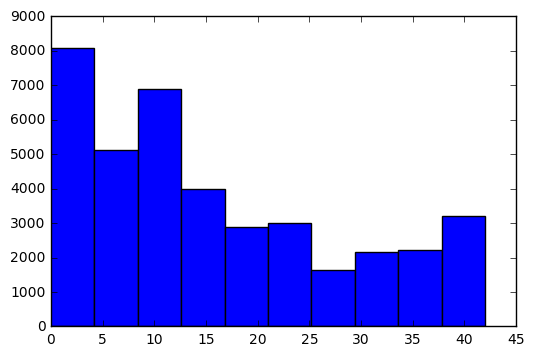

In [184]:
### To start off let's do a basic data summary.
# TODO: number of training examples
#n_train = len(train['features'])
n_train = len(X_train)
# TODO: number of testing examples
n_test = len(X_test)
# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]
# TODO: how many classes are in the dataset
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
plt.hist(y_train)
plt.show()
# Code to validate the count of each label
labels_dict = {}
for i in y_train:
    if i in labels_dict:
        labels_dict[i] = labels_dict[i]+1
    else:
        labels_dict[i] =1
#for key in labels_dict:
    #print(key, 'corresponds to', labels_dict[key])

In [185]:
### Data exploration visualization goes here.
def plot_images(images, true_lbl, pred_lbl=None):
    """
    Create 3X3 plot for plotting the images with true label and predicted label.
    Args:
    images = Images dataset
    true_lbl = Actual labels for the images dataset
    pred_lbl = Labels predicted by the model
    """
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i])
        
        # show true and predicted labels
        if pred_lbl is None:
            xlabel = "True: {0}".format(true_lbl[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_lbl[i], pred_lbl[i])
        ax.set_xlabel(xlabel)
        
        #Remove the ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])




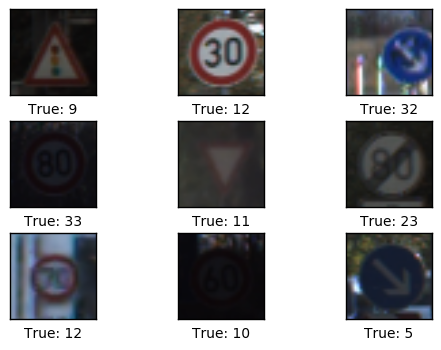

In [29]:
# get first 9 images from the train-set
plot_images(X_train[np.random.choice(len(X_train),9)],np.random.choice(y_train,9))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [186]:
### Pickel Train Datasets are sorted by label number so shuffling the datsets
# Shuffle the Train Data
id_train = np.arange(n_train)
np.random.shuffle(id_train)
X_train = X_train[id_train]
y_train = y_train[id_train]

# Shuffle the test data set
id_test = np.arange(n_test)
np.random.shuffle(id_test)
X_test = X_test[id_test]
y_test = y_test[id_test]



In [187]:
# Transform Functions to generate new images
import cv2
# Helper Functions
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

# Run the code to generate new images
X_train_m=[] # List to store Modified images
y_train_m=[] # List to store labels of modified images
X_gen_train = X_train[0::50]
y_gen_train = y_train[0::50]
for i in range(len(X_gen_train)):
    for i in range(10):
        img = transform_image(X_gen_train[i], 20,10,5)
        lbl = y_gen_train[i]
        X_train_m.append(img)
        y_train_m.append(lbl)
np.asarray(X_train_m)
np.asarray(y_train_m)
X_train_final = np.concatenate((X_train, X_train_m))
y_train_final = np.concatenate((y_train, y_train_m),axis=0)
print(X_gen_train.shape,y_gen_train.shape,X_train_final.shape,y_train_final.shape)

(785, 32, 32, 3) (785,) (47059, 32, 32, 3) (47059,)


In [188]:
# Split train data as 80-20 percentage for input and validation sets
split = int(0.8*len(X_train))
val_split = len(X_train) - split
X_ip = X_train[0:split]
X_val = X_train[split:]
y_ip = y_train[0:split]
y_val = y_train[split:]

In [189]:
# Helper function to Normalize image data

def normalize_scale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    
    X = image_data
    Xmin = 0
    Xmax = 255
    a=0.1
    b=0.9
    
    return a+(((X - Xmin)* (b-a))/(Xmax - Xmin))


# Normalize the imge intensity data on test and validation dataset
image_pixels = image_shape[0]*image_shape[1]*image_shape[2]
X_ip = normalize_scale(X_ip)
#X_val = normalize_scale(X_val)

In [34]:
# Build the inference graph
def cnn_inference(images):
    """Build the model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
   
    #Builder functions
    def new_weights(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=1.0 / math.sqrt(float(shape[0]))))

    def new_biases(length):
        return tf.Variable(tf.constant(0.05, shape=[length]))
    
    def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights aka. filters with the given shape.
        weights = new_weights(shape=shape)

        # Create new biases, one for each filter.
        biases = new_biases(length=num_filters)

        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions..
        # The padding is set to 'SAME' to keep Output same
        layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

        # Use pooling to down-sample the image resolution?
        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

        # Rectified Linear Unit (ReLU).
        layer = tf.nn.relu(layer)

        # We return both the resulting layer and the filter-weights
        # because we will plot the weights later.
        return layer, weights

    def flatten_layer(layer):
        # Get the shape of the input layer.
        layer_shape = layer.get_shape()

        # The shape of the input layer is assumed to be:
        # layer_shape == [num_images, img_height, img_width, num_channels]

        # The number of features is: img_height * img_width * num_channels
        # We can use a function from TensorFlow to calculate this.
        num_features = layer_shape[1:4].num_elements()
    
        # Reshape the layer to [num_images, num_features].
        layer_flat = tf.reshape(layer, [-1, num_features])

        # The shape of the flattened layer is now:
        # [num_images, img_height * img_width * num_channels]

        # Return both the flattened layer and the number of features.
        return layer_flat, num_features

    def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

        # Create new weights and biases.
        weights = new_weights(shape=[num_inputs, num_outputs])
        biases = new_biases(length=num_outputs)

        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases

        # Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer
    
    # Define The Constants for Building the COnvolution Layer
    # Convolutional Layer 1.
    filter1_size = 5          # Convolution filters are 5 x 5 pixels.
    num_filters1 = 16         # There are 16 of these filters.

    # Convolutional Layer 2.
    filter2_size = 5          # Convolution filters are 5 x 5 pixels.
    num_filters2 = 36         # There are 36 of these filters.
    
    # Convolutional Layer 3.
    filter3_size = 5          # Convolution filters are 5 x 5 pixels.
    num_filters3 = 36         # There are 36 of these filters.

    # Fully-connected layer.
    fc1_size = 512             # Number of neurons in fully-connected layer.
    
    # Fully-connected layer.
    fc2_size = 128             # Number of neurons in fully-connected layer.

    # Number of classes, one class for each of 43 digits.
    n_classes = 43
    
    # Build the Convolution Layer
    layer_conv1, weights_conv1 = \
            new_conv_layer(input=images,
                   num_input_channels=n_channels,
                   filter_size=filter1_size,
                   num_filters=num_filters1,
                   use_pooling=True)
    #layer_conv1 = tf.nn.dropout(layer_conv1, 0.75)
    #print(weights_conv1.get_shape(), layer_conv1.get_shape())
    
    layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter2_size,
                   num_filters=num_filters2,
                   use_pooling=True)
    layer_conv2 = tf.nn.dropout(layer_conv2, 0.75)
    
    #layer_conv3, weights_conv3 = \
    #new_conv_layer(input=layer_conv2,
                   #num_input_channels=num_filters2,
                   #filter_size=filter3_size,
                   #num_filters=num_filters3,
                   #use_pooling=True)
    #layer_conv3 = tf.nn.dropout(layer_conv3, 0.75)
    #print(weights_conv2.get_shape(), layer_conv2.get_shape())
    
    # Flatten the Output from Convolution so that it can be fed to Fully Connected Layer
    layer_flat, num_features = flatten_layer(layer_conv2)
    #layer_flat = tf.nn.dropout(layer_flat, 0.75)

    # First Fully Connected Layer
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc1_size,
                         use_relu=True)
    layer_fc1 = tf.nn.dropout(layer_fc1, 0.75)
    
    # Second Fully Connected Layer
    #layer_fc2 = new_fc_layer(input=layer_fc1,
                         #num_inputs=fc1_size,
                         #num_outputs=fc2_size,
                         #use_relu=True)
    #layer_fc2 = tf.nn.dropout(layer_fc2, 0.75)

    # Third Fully Connected Layer
    logits = new_fc_layer(input=layer_fc1,
                         num_inputs=fc1_size,
                         num_outputs=n_classes,
                         use_relu=False)  

    return logits

In [35]:
def cnn_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, n_classes].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, n_classes).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.AdamOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

In [41]:
# Constants for training the data
learning_rate = 0.0001
training_epochs = 10000
batch_size = 128
eval_size = 9
display_step = 1
TRAIN_DIR = 'data/cnn/dropout/'
# images are 32 pixels in each dimension.
img_size = 32

# Number of colour channels for the images: 1 channel for gray-scale.
n_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * n_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size, n_channels)

In [42]:
import tensorflow as tf
import math
import os
# Build the graph for feeding inputs, training, and saving checkpoints.
traffic_graph = tf.Graph()
with traffic_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32, shape=[None, img_size, img_size, n_channels]) 
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits = cnn_inference(images_placeholder)
    print(logits.get_shape())
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss = cnn_training(logits, labels_placeholder, learning_rate)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "complete.pbtxt", as_text=True)

(?, 43)


In [43]:
# 2.7 Run training for max_steps and save checkpoint at the end.
with tf.Session(graph=traffic_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)

    # Start the training loop.
    for epoch in range(training_epochs):
        # Read a batch of images and labels.
        idx = np.random.choice(int(0.8*n_train), size=batch_size)
        images_feed = X_ip[idx]
        labels_feed = y_ip[idx]

        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={images_placeholder: images_feed,
                                            labels_placeholder: labels_feed})

        # Print out loss value.

        if epoch % 1000 == 0:
            print('epoch %d: loss = %.2f' % (epoch, loss_value))
            #print(loss_value,learning_rate)
    # Write a checkpoint.
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=epoch)

epoch 0: loss = 8.30
epoch 1000: loss = 0.88
epoch 2000: loss = 0.50
epoch 3000: loss = 0.15
epoch 4000: loss = 0.09
epoch 5000: loss = 0.05
epoch 6000: loss = 0.08
epoch 7000: loss = 0.03
epoch 8000: loss = 0.04
epoch 9000: loss = 0.03


In [190]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    # Run evaluation on Validation Set
    images_feed = X_val
    labels_feed = y_val
    #imgplot = plt.imshow(X_test[i])
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed,
                                     labels_placeholder: labels_feed})
    labels_pred = np.squeeze(prediction.indices)
    #y_pred_cls = tf.argmax(prediction, dimension=2)
    #plot_images(X_val[20:29],labels_feed[20:29],labels_pred[20:29])
    print("Accuracy of the Validation data test is :", np.mean(np.equal(labels_feed,labels_pred)))

Accuracy of the Validation data test is : 0.979979597042


Accuracy of the test set is : 0.866349960412


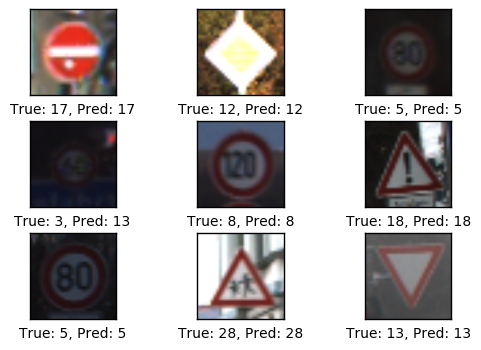

In [191]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    # Run evaluation on training data

    images_feed = X_test
    labels_feed = y_test
    #imgplot = plt.imshow(X_test[i])
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed,
                                     labels_placeholder: labels_feed})
    labels_pred = np.squeeze(prediction.indices)
    #y_pred_cls = tf.argmax(prediction, dimension=2)
    plot_images(X_test,labels_feed,labels_pred)
    print("Accuracy of the test set is :", np.mean(np.equal(labels_feed,labels_pred)))

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [16]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

Read the input data provided as pickle dataset. The images are already converted to 32 X 32 pixels.
But when I review the data the dataset is sorted by the labels type.
Here are the preprocess steps I have performed:  
1) Shuffle the image data and the labels data. Used Numpy random.shuffle function  
2) After testing with different type of Convolution approaches (using different functions like pooling, droput etc),the accuracy was stagnant. I have observed that the model was performing better on validation datset than on training dataset. To add further variation I used transform_image function above to generate new images from a given image in different angles etc..  
3) Split the 80% of data as train dataset and 20% as validation dataset  
4) Normalize the image intensisty to 0.1 to 0.9 scale  

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

I have used the pickle dataset provided by Udacity. Used two data files train.p and test.p provided in the project resources. train.p is kept separate for testing.

On training data (read from train.p file), First I shuffled the data and then read every 50th record from the datset and generated 10 new images from each image at different angels. Total number of new images generated: 785*10 = 7850

I felt my data is ovefit and to reduce that I have used same images with different angles and shear.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [18]:
# Heare the Constants used for the model.

learning_rate = 0.001 # Used multiple values like 0.0001, 0.001, 0.01 etc
training_epochs = 10000
batch_size = 128 # Tries 64, 256 and finally settled with 128
img_size = 32 # images are 32 pixels in each dimension.
n_channels = 3 # Number of colour channels for the images: 1 channel for gray-scale.


# Define The Constants for Building the COnvolution Layer
# Convolutional Layer 1.
filter1_size = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter2_size = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.
    
# Convolutional Layer 3.
filter3_size = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 36         # There are 36 of these filters.

# Fully-connected layer1
fc1_size = 512             # Number of neurons in fully-connected layer.
    
# Fully-connected layer2
fc2_size = 128             # Number of neurons in fully-connected layer.

# Number of classes, one class for each of 43 digits.
n_classes = 43

# Max Pooling 2X2

# Weights and Biases are as follows
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=1.0 / math.sqrt(float(shape[0]))))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


Architecture of My Model:
    Convolution Layer 1
        Filter Size: 5X5
        Filters: 16
        Max Pooling: 2X2
        RELU
        Dropout: 75%
    Convolution layer 2
         Filter Size: 5X5
        Filters: 36
        Max Pooling: 2X2
        RELU
        Dropout: 75%        
    Flatten The COnvolution Data:
        Flatten the Conv data    
    Fully Connected Layer 1
        No. of hidden units: 512
        Apply RELU
    Fully COnnected Layer 2
        No. of hidden unit: 128
        Apply RELU
        

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Type of Optimizer: AdamOptimizer
Batch size: 128 (Trained with different bactches like 64, 256 etc but finally settled for 128)
epochs: 10,000
hyperparameters: LearningRate 0.001 (Used different values but settled on 0.001)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First I created a linear model with 2 layers to test the data. Once it started classifying the images with good accuract, I moved to COnvolution architecture.

First Shuffled the trainng data, selected 80% data for training and 20% for validating the data.
Randomly select the batchsize data from the trianing dataset and use that for training a single batch. 
AFter that I have added dropout to generalize the model and then introduced some test data (generated images with different angles).

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [204]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.image as mpimg

# Helper Function to read images and convert to 32X32 images
def image_preprocess(image):
    dim = (32,32)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

# Directory of test images
READ_DIR = 'mod/'
test_list = []
labels_list = []
raw_images = os.listdir(READ_DIR)
for img in raw_images:
    image = mpimg.imread(READ_DIR+img)
    #print(image.shape, img)
    image_m = image_preprocess(image)
    #print(image_m.shape, img)
    test_list.append(image_m)
    labels_list.append(img)
    #plt.imshow(image_m)
    #plt.show()
X_web=np.asarray(test_list)
#plt.imshow(X_web[0])
#plt.show()
#print(X_web.shape)

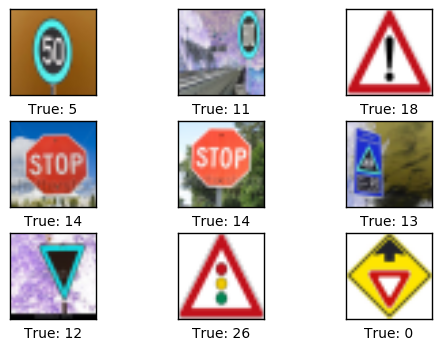

In [177]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits,k=1)
    # Run evaluation on training data

    images_feed = X_web
    #labels_feed = y_web
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed})
    labels_pred = np.squeeze(prediction.indices)
    #print(labels_pred)
    plt.show()
    plot_images(X_web[5:],labels_pred[5:])
    #print("Accuracy of the test set is :", np.mean(np.equal(labels_feed,labels_pred)))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

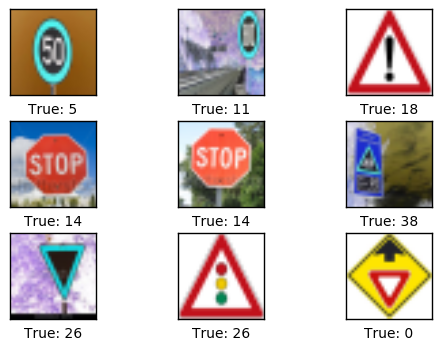

In [178]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits,k=1)
    # Run evaluation on training data

    images_feed = X_web
    #labels_feed = y_web
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed})
    labels_pred = np.squeeze(prediction.indices)
    #print(labels_pred)
    plt.show()
    plot_images(X_web[5:],labels_pred[5:])
    #print("Accuracy of the test set is :", np.mean(np.equal(labels_feed,labels_pred)))

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

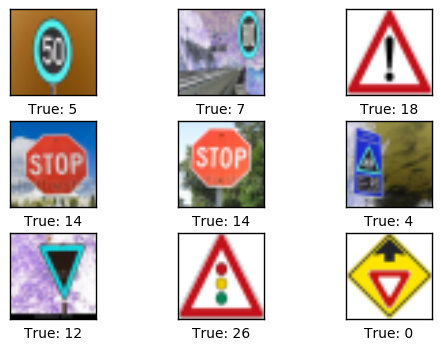

In [180]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits,k=5)
    # Run evaluation on training data

    images_feed = X_web
    #labels_feed = y_web
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed})
    labels_pred = np.squeeze(prediction.indices)
    #print(labels_pred)
    plt.show()
    plot_images(X_web[5:],labels_pred[5:])
    #print("Accuracy of the test set is :", np.mean(np.equal(labels_feed,labels_pred)))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

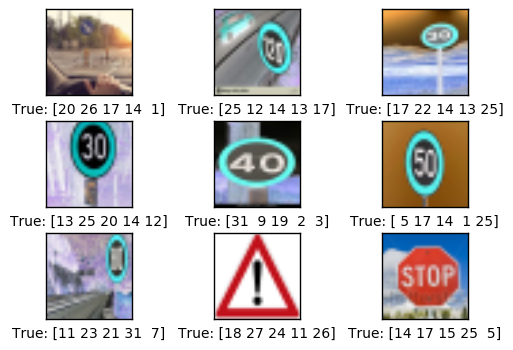

In [206]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-9999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-9999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    #ide = np.random.choice(n_test, size=eval_size)
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits, k=5)
    # Run evaluation on training data

    images_feed = X_web

    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed})
    labels_pred = np.squeeze(prediction.indices)
    plt.show()
    plot_images(X_web,labels_pred)


In [ ]:
Model is certain when the traffic signs occupy most of the area in the image. 
If I take a image from web and downsample it to 32X32, the traffic signal becomes small in the whole area and thats
when the model is not able to predict it. If I extract only traffic signal from the image and downsample it 32X32,
the model predicts better.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
My interface is manual at the moment and need some more work to automate the image colection.
I have saved the images manually in a folder from the web and then ran the helper function 
image_preprocess function(function shown in Step3, Implementation notes) to downsample the images to 32X32

After that, I have used the model information that is already saved to classify the images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.